# Tensorflow classificator
In this notebook I will implement a simple supervised classificator using tensorflow
## Loading the data
First I'll load the data and will separate it for classification

In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

In [2]:
#loading the data
# This dataset was generated in the 4.0-comparison-supervised-algorithms.ipynb notebook
from benchtools.src.datatools import read_multifiles
df = read_multifiles(filename='RD_dataset', nbatch=10)
df.head()

,pT_j1,m_j1,eta_j1,phi_j1,E_j1,tau_21_j1,nhadrons_j1,pT_j2,m_j2,eta_j2,phi_j2,E_j2,tau_21_j2,nhadrons_j2,m_jj,deltaR_j12,n_hadrons,label
0,1286.727685,106.912129,0.185508,-2.763676,1313.290435,0.624659,36,1283.220733,63.164215,0.064989,0.393688,1287.481934,0.713248,33,2580.489568,3.159663,109.0,0.0
1,1354.394070,614.269108,0.826505,1.365524,1943.559886,0.311688,84,1325.613761,439.064150,-0.874319,-1.786248,1916.370744,0.276881,97,3859.315047,3.581406,208.0,0.0
2,1214.955723,645.865619,-0.196786,2.040545,1396.840654,0.238205,119,1072.462085,113.768840,0.143831,-1.090330,1089.530630,0.726963,59,2480.769725,3.149348,196.0,0.0
3,1285.227873,516.835248,0.328693,2.975321,1450.485926,0.013429,65,1220.251279,174.796077,0.294854,-0.322661,1285.618789,0.706361,89,2609.893413,3.298155,183.0,0.0
4,1210.415787,129.499352,-0.744836,-2.883347,1567.345300,0.423550,54,1091.785816,155.362262,1.060534,0.264977,1772.340209,0.787662,57,3313.488835,3.629229,169.0,1.0


I need to get the data ready for classification:

In [3]:
from sklearn.preprocessing import MinMaxScaler
from benchtools.src.datatools import separate_data
from sklearn.model_selection import train_test_split

# Separating characteristics from label
X, y = separate_data(df, standardize=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# Eliminating the columns of mass so that the training is model-free 
X_train_nm = X_train.drop(['m_j1', 'm_j2', 'm_jj'], axis=1)
X_test_nm = X_test.drop(['m_j1', 'm_j2', 'm_jj'], axis=1)

# Standarizing the variables
scaler = MinMaxScaler()
X_train_nm[X_train_nm.columns] = scaler.fit_transform(X_train_nm[X_train_nm.columns])
X_test_nm[X_test_nm.columns] = scaler.fit_transform(X_test_nm[X_test_nm.columns])


X_train_nm.head()

,pT_j1,eta_j1,phi_j1,E_j1,tau_21_j1,nhadrons_j1,pT_j2,eta_j2,phi_j2,E_j2,tau_21_j2,nhadrons_j2,deltaR_j12,n_hadrons
13950,0.023766,0.447932,0.572749,0.026637,0.194259,0.177165,0.236204,0.319188,0.073249,0.228341,0.187415,0.170732,0.468489,0.135043
40914,0.163466,0.512338,0.824834,0.110933,0.288922,0.240157,0.329691,0.687570,0.317613,0.344764,0.245672,0.178862,0.495242,0.184615
23239,0.073016,0.411868,0.253741,0.062484,0.412827,0.244094,0.282658,0.334711,0.745132,0.259233,0.184162,0.321138,0.446029,0.249573
39807,0.014362,0.379798,0.973110,0.043124,0.493650,0.244094,0.242288,0.251246,0.438868,0.310071,0.313793,0.272358,0.524856,0.244444
21877,0.066394,0.255427,0.177565,0.216971,0.459898,0.074803,0.166781,0.368110,0.719979,0.130329,0.703020,0.186992,0.533256,0.150427


## Model
Here I'll create the model and train it. First I'm going to state the construction of the model

In [4]:
# How many characteristics we are using
input_shape = [X_train_nm.shape[1]]

# Creating the model
# Here are the layers with batch normalization, the drop out rate and the activations
model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),   
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),   
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),   
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),   
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'),
])

We also need a loss function

In [5]:
# Choosing the optimizer
# Binary crossentropy for binary classification
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],)

# We use early stop to prevent the model from overfitting
early_stopping = keras.callbacks.EarlyStopping(
    patience=20,
    min_delta=0.001,
    restore_best_weights=True,
)

## Training
Now, I'll train the model

In [6]:
history = model.fit(
    X_train_nm, y_train,
    validation_data=(X_test_nm, y_test),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
)

Epoch 1/200
700/700 [==============================] - 65s 90ms/step - loss: 0.1890 - binary_accuracy: 0.9336 - val_loss: 0.1223 - val_binary_accuracy: 0.9544
Epoch 2/200
700/700 [==============================] - 59s 85ms/step - loss: 0.1265 - binary_accuracy: 0.9529 - val_loss: 0.1179 - val_binary_accuracy: 0.9558
Epoch 3/200
700/700 [==============================] - 71s 101ms/step - loss: 0.1218 - binary_accuracy: 0.9548 - val_loss: 0.1159 - val_binary_accuracy: 0.9563
Epoch 4/200
700/700 [==============================] - 77s 110ms/step - loss: 0.1192 - binary_accuracy: 0.9557 - val_loss: 0.1186 - val_binary_accuracy: 0.9554
Epoch 5/200
700/700 [==============================] - 89s 127ms/step - loss: 0.1170 - binary_accuracy: 0.9565 - val_loss: 0.1127 - val_binary_accuracy: 0.9575
Epoch 6/200
700/700 [==============================] - 86s 123ms/step - loss: 0.1155 - binary_accuracy: 0.9572 - val_loss: 0.1113 - val_binary_accuracy: 0.9582
Epoch 7/200
700/700 [=====================

## Classification
Once the model is trained, I can use it to predict the probability of each event being signal or background

In [7]:
y_prob = model.predict(X_test_nm)
my_list = map(lambda x: x[0], y_prob)
y_pred = pd.Series(my_list)

y_pred.head()

0    0.072683
1    0.003764
2    0.003915
3    0.000218
4    0.000384
dtype: float32

We want to convert this probability to 0 or 1, to be able to calculate metrics about the performance of the classificator

In [9]:
# Adding the series to the dataframe with the masses
X_test = X_test.assign(y_test=pd.Series(y_test).values)
X_test = X_test.assign(y_pred=pd.Series(y_pred).values)
# Here I choose 0.5 as the threshole but that can be changed
# and can affect the metrics
X_test['y_pred']=(X_test['y_pred'] >= .5).astype(float)

X_test.head()

,pT_j1,m_j1,eta_j1,phi_j1,E_j1,tau_21_j1,nhadrons_j1,pT_j2,m_j2,eta_j2,phi_j2,E_j2,tau_21_j2,nhadrons_j2,m_jj,deltaR_j12,n_hadrons,y_test,y_pred
7704,1245.335366,589.122521,-0.591652,2.566940,1583.408925,0.252553,100,1113.805169,61.245864,0.801365,-0.797360,1492.250629,0.301229,31,3054.421585,3.641292,191.0,0.0,0.0
13843,1490.167755,123.532076,0.163960,0.372214,1515.286474,0.709907,39,1419.495073,60.903034,0.001545,-2.751416,1420.802678,0.440108,27,2924.658648,3.127850,109.0,0.0,0.0
44955,1436.961210,101.657847,-0.488022,0.427252,1614.704990,0.620576,31,1061.226122,282.394158,0.430838,-2.555102,1195.095384,0.343264,88,2765.624632,3.120696,195.0,0.0,0.0
6850,1261.358720,218.808374,1.172695,1.354259,2243.439433,0.726776,51,1201.313206,287.944492,-1.255317,-1.732465,2296.971844,0.347862,112,4538.534805,3.927227,234.0,0.0,0.0
44215,1300.249334,232.676144,0.123892,2.329810,1330.740280,0.933545,64,1224.618066,150.389562,-0.065651,-0.714245,1236.438223,0.409710,42,2561.831397,3.049950,183.0,0.0,0.0


## Performance
Some variables like precision or the f1 score will tell us about how good the classificator did. First I'm going to get a general report

In [10]:
from sklearn.metrics import precision_score, log_loss, recall_score, plot_confusion_matrix,classification_report, f1_score

print(classification_report(X_test['y_test'], X_test['y_pred'], target_names=['background','signal']))

              precision    recall  f1-score   support

  background       0.97      0.99      0.98    139578
      signal       0.85      0.66      0.74     14022

    accuracy                           0.96    153600
   macro avg       0.91      0.82      0.86    153600
weighted avg       0.96      0.96      0.96    153600



And some specific variables I'm interested in:

In [11]:
precision = precision_score(y_test, X_test['y_pred'])
ll = log_loss(y_test, y_prob)
f1 = f1_score(y_test, X_test['y_pred'])
recall = recall_score(y_test, X_test['y_pred'])

print('recall: {0:.2}, precision: {0:.2%}, log loss: {0:.2f}, f1 score:{0:.2f}'.format(recall, precision*100, ll, f1))

recall: 0.66, precision: 65.63%, log loss: 0.66, f1 score:0.66


Here I will define some functions to calculate the values for the ROC curve and the AUC and the plot. Later those should be on the benchtools package

In [12]:
from sklearn.metrics import roc_auc_score, roc_curve
def roc_curve_and_score(y_test, pred_proba):
    fpr, tpr, _ = roc_curve(y_test.ravel(), pred_proba.ravel())
    roc_auc = roc_auc_score(y_test.ravel(), pred_proba.ravel())
    return fpr, tpr, roc_auc

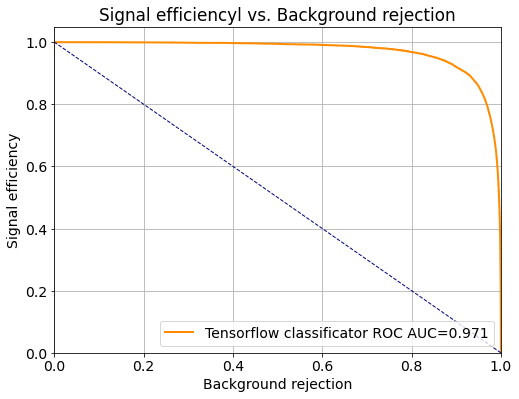

In [13]:
import matplotlib

plt.figure(figsize=(8, 6))
matplotlib.rcParams.update({'font.size': 14})
plt.grid()

fpr, tpr, roc_auc = roc_curve_and_score(y_test, y_prob)
plt.plot(1-fpr, tpr, color='darkorange', lw=2,
         label='{} ROC AUC={:.3f}'.format('Tensorflow classificator', roc_auc))

plt.plot([1, 0], [0, 1], color='navy', lw=1, linestyle='--')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background rejection')
plt.ylabel('Signal efficiency')
plt.title('Signal efficiencyl vs. Background rejection')
plt.show()

## The prediction
Here we can take a look of how the prediction looks vs. how the real data is distributed

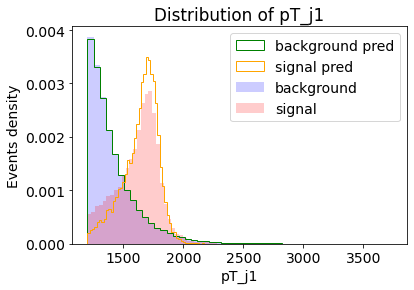

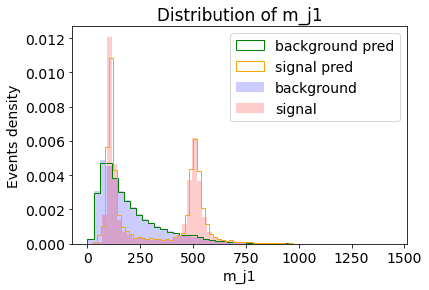

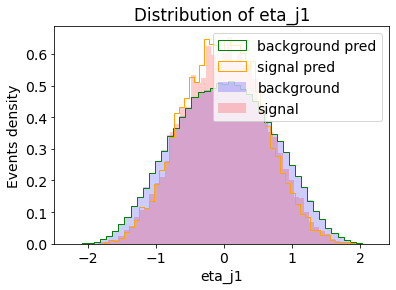

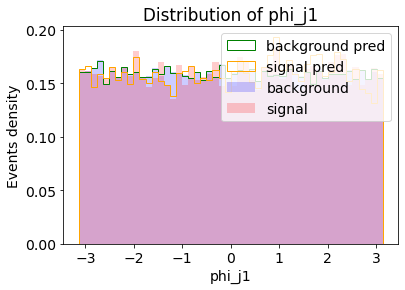

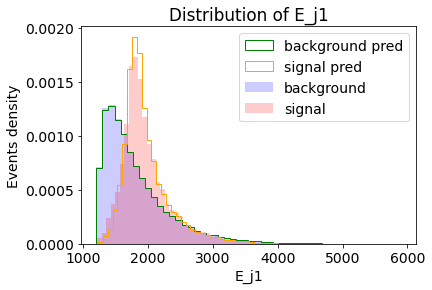

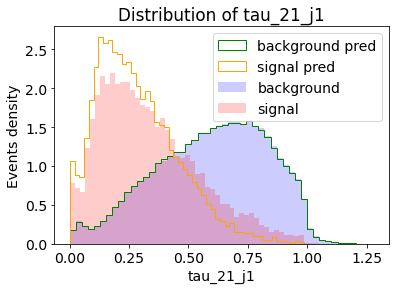

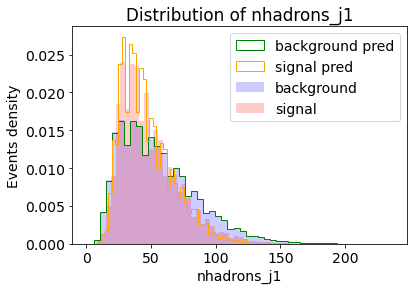

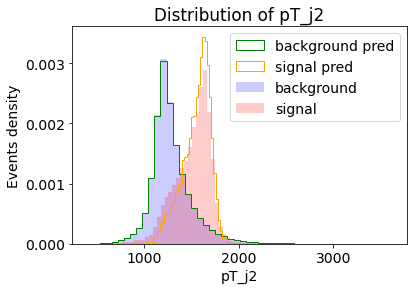

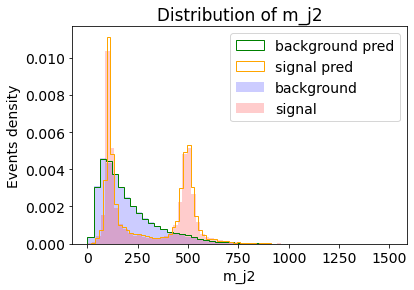

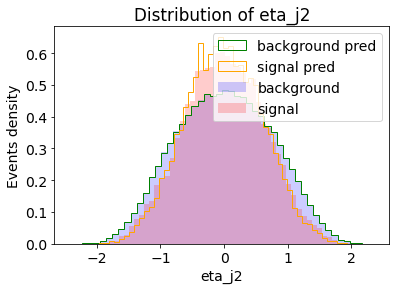

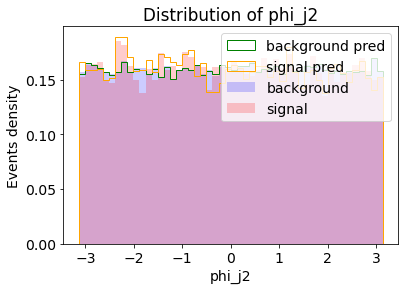

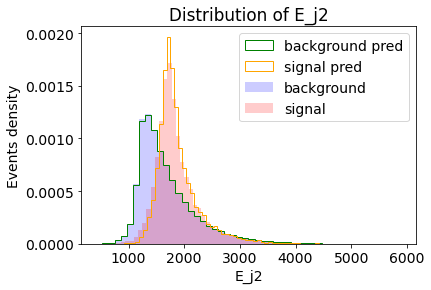

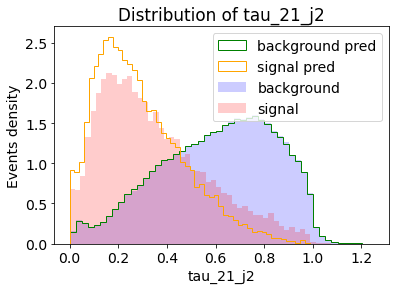

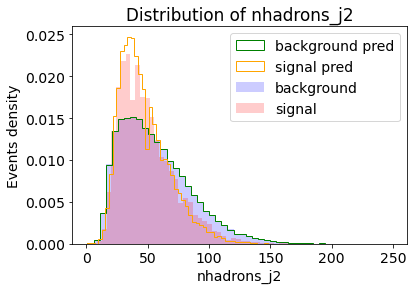

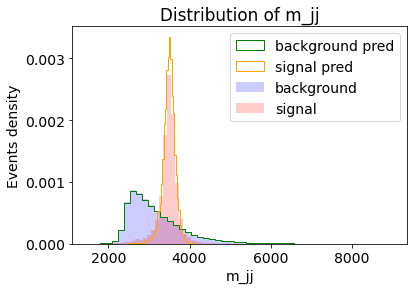

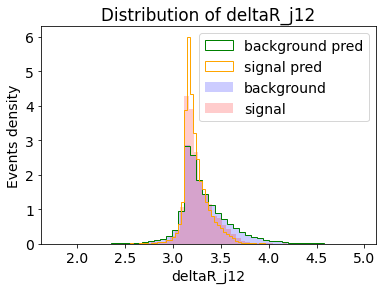

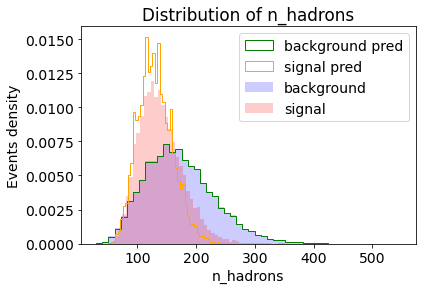

In [14]:
from benchtools.src.plotools import pred_test_hist
variables=X_test.drop(['y_pred','y_test'], axis=1).columns.tolist()

for variable in variables:
    pred_test_hist(X_test, variable, ypred='y_pred', ytest='y_test', n_bins=50, log=False)

## BB1 dataset
I'm going to calculate the performance variables for the predictions on the BB1 dataset with the model trained above. Then the plots of how the data is distributed according to the prediction vs. the real distributions.

In [15]:
# Loading the data
df_bb = read_multifiles(filename='BB1_dataset', nbatch=10)
df_bb.head()

,pT_j1,m_j1,eta_j1,phi_j1,E_j1,tau_21_j1,nhadrons_j1,pT_j2,m_j2,eta_j2,phi_j2,E_j2,tau_21_j2,nhadrons_j2,m_jj,deltaR_j12,n_hadrons,label
0,1397.005228,170.225610,-0.765391,0.537239,1834.490410,0.543602,70,1347.988973,427.365520,0.225140,-2.740281,1446.853969,0.880080,82,3157.841212,3.423930,230.0,0.0
1,1273.332773,327.845663,0.354693,-0.951367,1393.391014,0.403889,77,1034.297905,106.489303,-0.364250,2.119474,1108.799742,0.927609,44,2488.262160,3.153878,156.0,0.0
2,1268.472197,72.622808,-1.055852,-0.319414,2045.001255,0.685529,21,1133.216562,456.691841,0.738184,2.727534,1526.179769,0.073868,54,3499.867409,3.535882,134.0,0.0
3,1414.022037,208.706758,-0.428495,2.622507,1559.858883,0.405329,81,1364.308129,60.057918,-0.242186,-0.992484,1405.798737,0.638481,39,2729.477504,3.619790,247.0,0.0
4,1220.274012,170.788218,-0.076185,-1.373332,1235.676617,0.466025,38,1210.723592,402.915624,-0.275398,1.633799,1319.927141,0.097154,34,2513.728451,3.013722,148.0,0.0


In [16]:
# Preparing the data for classification
X, y = separate_data(df_bb, standardize=False)
# Eliminating masses for the model free classification
X_cl = X.drop(['m_j1','m_j2','m_jj'], axis=1)
# Standarizing the variables
scaler = MinMaxScaler()
X_cl[X_cl.columns] = scaler.fit_transform(X_cl[X_cl.columns])

In [17]:
# Predicting the probability
y_prob = model.predict(X_cl)
my_list = map(lambda x: x[0], y_prob)
y_pred = pd.Series(my_list)

y_pred.head()

0    0.000572
1    0.001011
2    0.067566
3    0.001450
4    0.020682
dtype: float32

In [18]:
# Adding the prediction and labels to the main dataframe
X = X.assign(y_test=pd.Series(y).values)
X = X.assign(y_pred=pd.Series(y_pred).values)
X['y_pred']=(X['y_pred'] >= .5).astype(float)

X.head()

,pT_j1,m_j1,eta_j1,phi_j1,E_j1,tau_21_j1,nhadrons_j1,pT_j2,m_j2,eta_j2,phi_j2,E_j2,tau_21_j2,nhadrons_j2,m_jj,deltaR_j12,n_hadrons,y_test,y_pred
0,1397.005228,170.225610,-0.765391,0.537239,1834.490410,0.543602,70,1347.988973,427.365520,0.225140,-2.740281,1446.853969,0.880080,82,3157.841212,3.423930,230.0,0.0,0.0
1,1273.332773,327.845663,0.354693,-0.951367,1393.391014,0.403889,77,1034.297905,106.489303,-0.364250,2.119474,1108.799742,0.927609,44,2488.262160,3.153878,156.0,0.0,0.0
2,1268.472197,72.622808,-1.055852,-0.319414,2045.001255,0.685529,21,1133.216562,456.691841,0.738184,2.727534,1526.179769,0.073868,54,3499.867409,3.535882,134.0,0.0,0.0
3,1414.022037,208.706758,-0.428495,2.622507,1559.858883,0.405329,81,1364.308129,60.057918,-0.242186,-0.992484,1405.798737,0.638481,39,2729.477504,3.619790,247.0,0.0,0.0
4,1220.274012,170.788218,-0.076185,-1.373332,1235.676617,0.466025,38,1210.723592,402.915624,-0.275398,1.633799,1319.927141,0.097154,34,2513.728451,3.013722,148.0,0.0,0.0


In [19]:
# Calculating the principal metris
precision = precision_score(y, X['y_pred'])
ll = log_loss(y, y_prob)
f1 = f1_score(y, X['y_pred'])
recall = recall_score(y, X['y_pred'])

print('recall: {0:.2}, precision: {0:.2%}, log loss: {0:.2f}, f1 score:{0:.2f}'.format(recall, precision*100, ll, f1))

recall: 0.57, precision: 57.47%, log loss: 0.57, f1 score:0.57


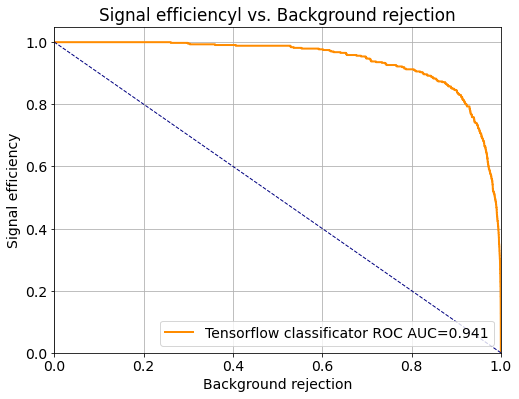

In [20]:
# ROC and AUC
plt.figure(figsize=(8, 6))
matplotlib.rcParams.update({'font.size': 14})
plt.grid()

fpr, tpr, roc_auc = roc_curve_and_score(y, y_prob)
plt.plot(1-fpr, tpr, color='darkorange', lw=2,
         label='{} ROC AUC={:.3f}'.format('Tensorflow classificator', roc_auc))

plt.plot([1, 0], [0, 1], color='navy', lw=1, linestyle='--')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background rejection')
plt.ylabel('Signal efficiency')
plt.title('Signal efficiencyl vs. Background rejection')
plt.show()

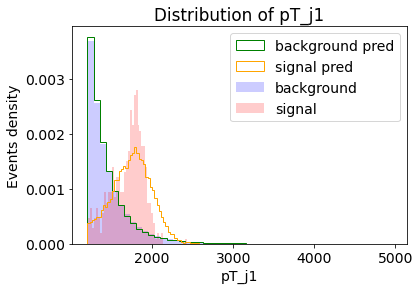

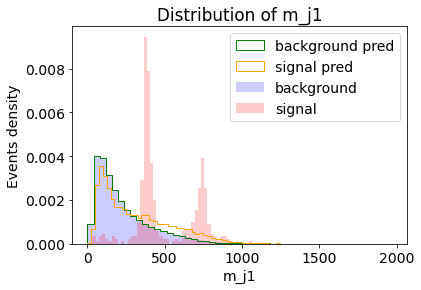

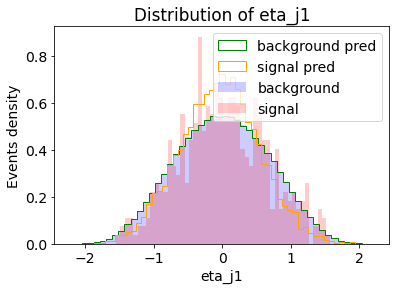

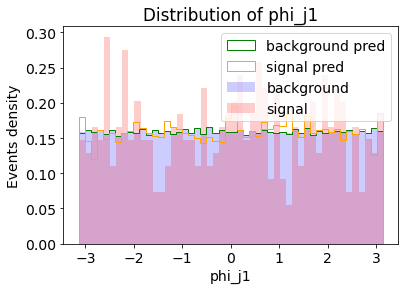

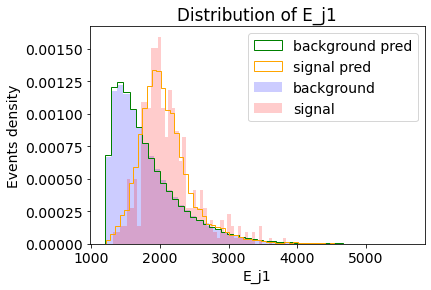

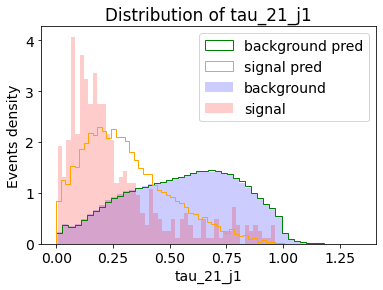

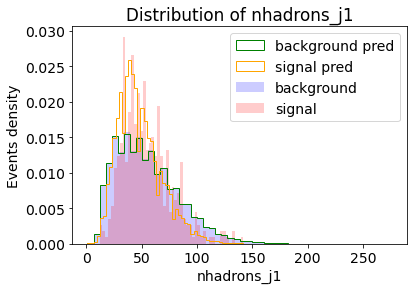

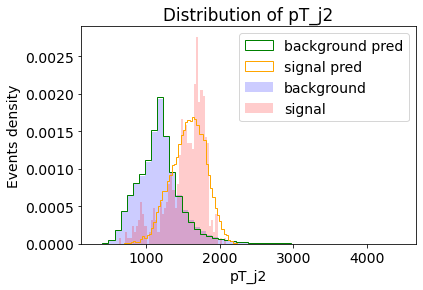

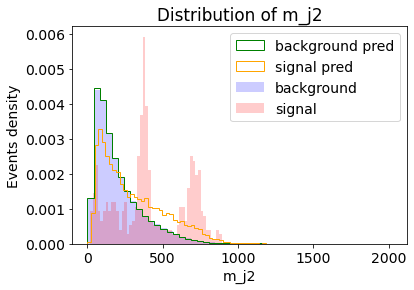

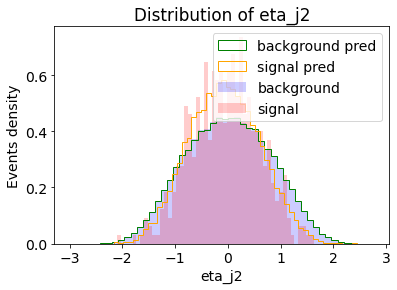

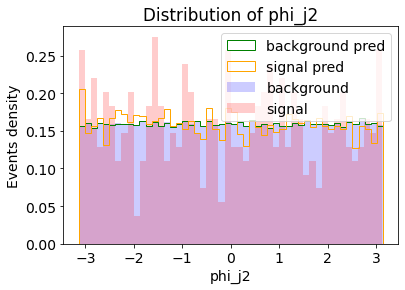

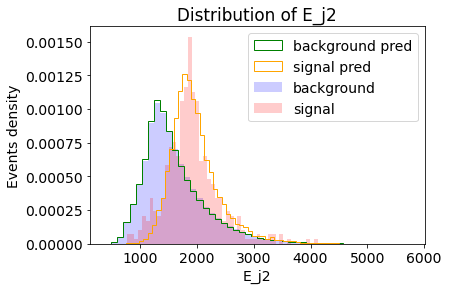

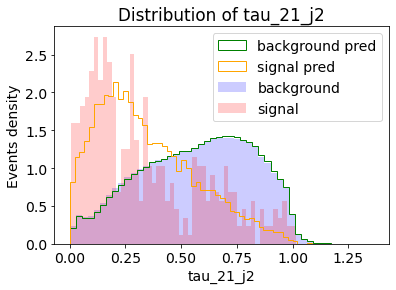

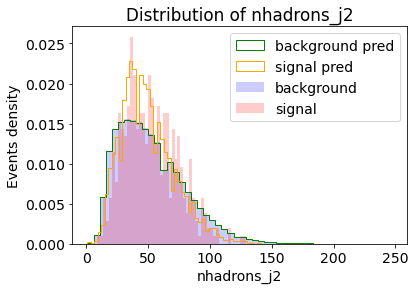

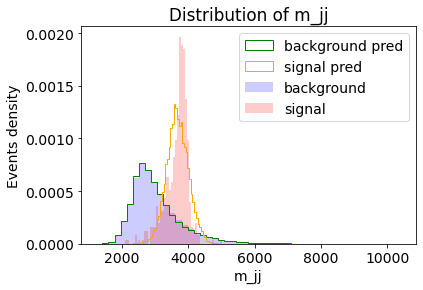

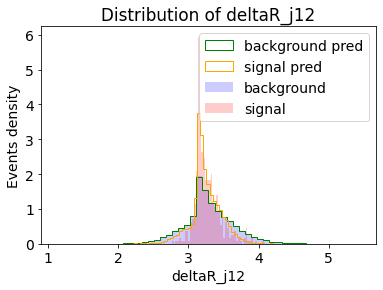

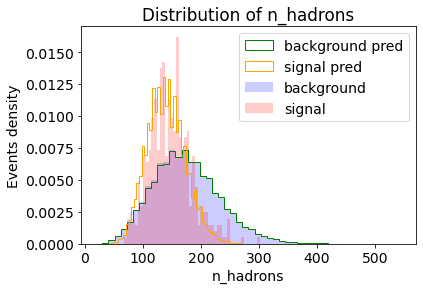

In [21]:
# The distributions
for variable in variables:
    pred_test_hist(X, variable, ypred='y_pred', ytest='y_test', n_bins=50, log=False)